
learning on dataset Raw Data
training: adam
Training set score: 0.792623
Test set score: 0.781278

learning on dataset Binary Conversion
training: adam
Training set score: 0.776082
Test set score: 0.764266

learning on dataset One-hot Encoded Data
training: adam
Training set score: 0.792623
Test set score: 0.781278

learning on dataset Standardized Data
training: adam
Training set score: 0.792623
Test set score: 0.781278


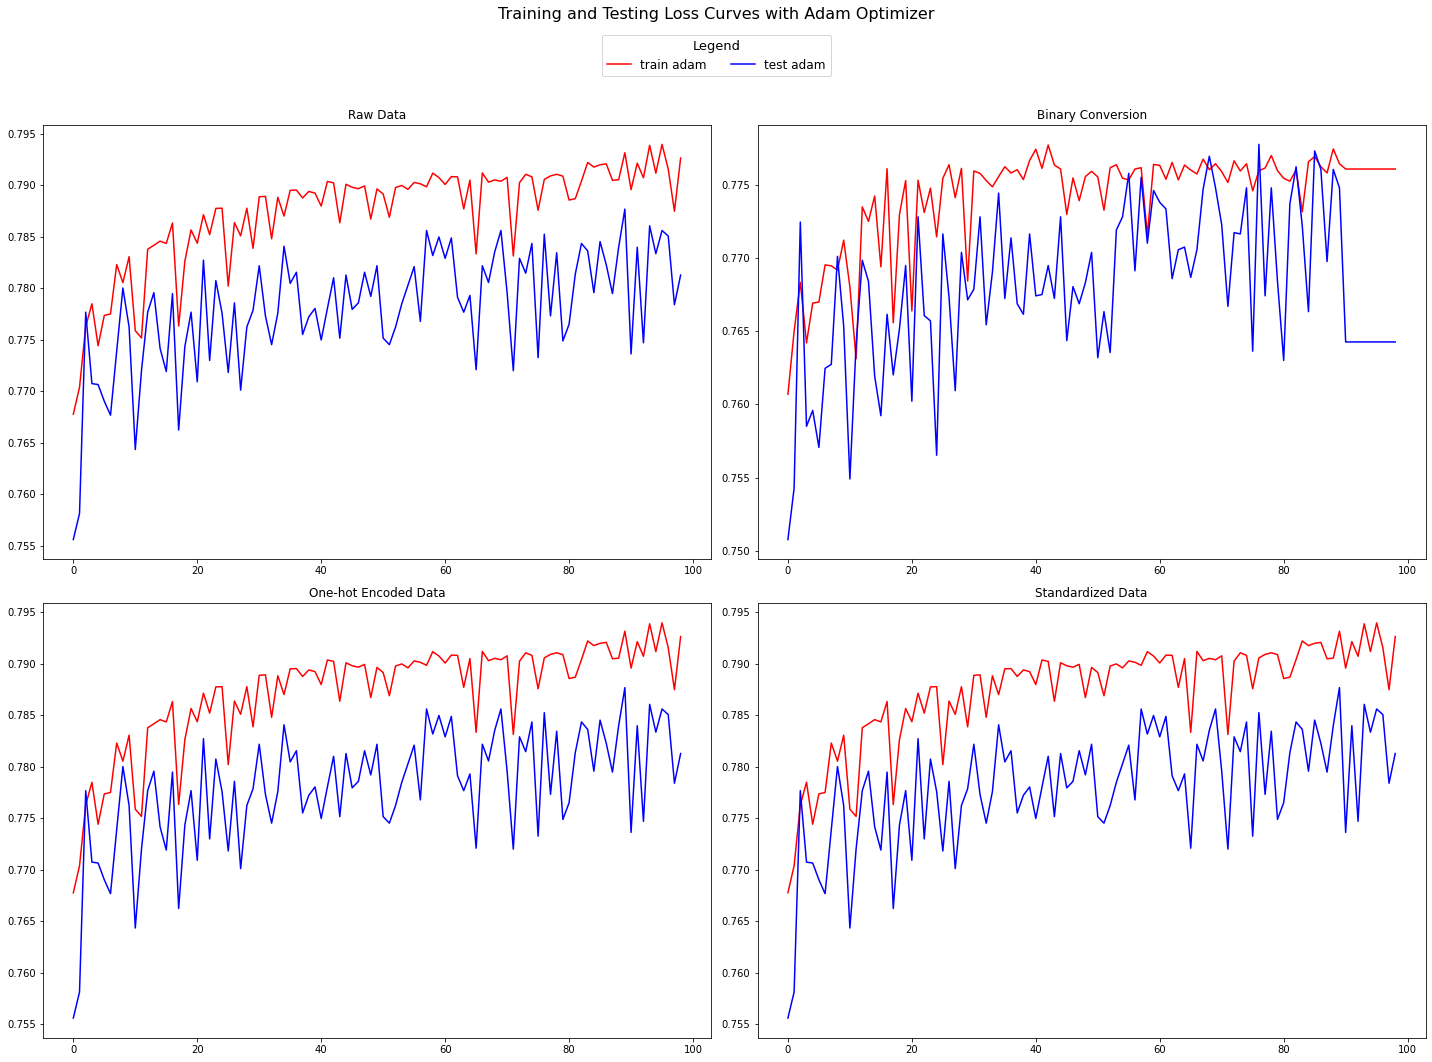

In [6]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

# Read dataset
filename = "NF-UQ-NIDS3.csv"
df = pd.read_csv(filename)

# Convert IP addresses to integer values
df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].apply(lambda x: int(''.join([bin(int(i)+256)[3:] for i in x.split('.')]), 2))
df['IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].apply(lambda x: int(''.join([bin(int(i)+256)[3:] for i in x.split('.')]), 2))

# Drop the 'Dataset' column
df = df.drop(columns=['Dataset'])

# One-hot Encoding
df = pd.get_dummies(df, columns=['Protocol', 'L7 Protocol'])

# Split your data into features and target
X = df.drop('Attack', axis=1)
y = df['Attack']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def to_binary(x):
    if isinstance(x, (int, float)):
        return format(int(x), 'b')
    else:
        return x

# Apply the same transformations to the training and testing datasets

# Binary Conversion
X_train_bin = X_train.applymap(to_binary)
X_test_bin = X_test.applymap(to_binary)

# Standardization
scaler = StandardScaler()

X_train_std = X_train.copy()
X_train_std = scaler.fit_transform(X_train_std)

X_test_std = X_test.copy()
X_test_std = scaler.transform(X_test_std)

# Define the MLP parameters and plot_args for the adam optimizer
params = [{"solver": "adam", "learning_rate_init": 0.01}]
labels = ["adam"]
plot_args = [{"c": "red", "linestyle": "-"}]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))  # increased size

def plot_on_dataset(X_train, y_train, X_test, y_test, name, ax):
    # plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    
    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=42, max_iter=1, **param)

        test_score = []
        train_score = []

        # some parameter combinations will not converge as can be seen on the plots so ignore them
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            for i in range(2, 101):  # train for 100 iterations
                mlp.set_params(max_iter=i)
                mlp.fit(X_train, y_train)
                train_score.append(mlp.score(X_train, y_train))
                test_score.append(mlp.score(X_test, y_test))
                
        print("Training set score: %f" % mlp.score(X_train, y_train))
        print("Test set score: %f" % mlp.score(X_test, y_test))

        ax.plot(train_score, 'r', label="train " + label) # plotting t, a separately 
        ax.plot(test_score, 'b', label="test " + label) # plotting t, b separately 
    
plot_on_dataset(X_train, y_train, X_test, y_test, "Raw Data", axes[0, 0])
plot_on_dataset(X_train_bin, y_train, X_test_bin, y_test, "Binary Conversion", axes[0, 1])
plot_on_dataset(X_train, y_train, X_test, y_test, "One-hot Encoded Data", axes[1, 0])
plot_on_dataset(X_train_std, y_train, X_test_std, y_test, "Standardized Data", axes[1, 1])

handles, labels = axes[0, 0].get_legend_handles_labels()  # get the handles and labels from any subplot

# Create a big legend for the whole figure using the handles and labels
fig.legend(handles, labels, loc="upper center", title="Legend", title_fontsize="13", fontsize="12", ncol=4, bbox_to_anchor=(0.5, 0.96))

# Add a centered title to the figure.
fig.suptitle("Training and Testing Loss Curves with Adam Optimizer", fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.92])  # adjust the subplots to make room for the legend and suptitle
plt.show()

